In [1]:
from mnist import MNIST 
import numpy as np
from pylab import *
from matplotlib import colors
%matplotlib inline

mndata = MNIST('./data')

mndata.load_training()
img_side = 28
n_mnist_pixels = img_side*img_side

In [2]:
labels = mndata.train_labels

cluster_size = 10
train_inputs_idx = []
for idx in range(10):
    label_idx = np.where(np.isin(labels,[idx]))[0][:cluster_size]
    train_inputs_idx.append(label_idx)

samples_idx = np.array(train_inputs_idx, dtype='int').flatten()
samples_idx.size

100

# TODO: Winner's stats synapse.
# TODO: Bio_hebbian stats synapse.
# TODO: Stats synapse for each rez.synapse, not only for winners.
# TODO: Stats synapse for winners and second after winner.
# TODO: Push stats synapses.
# TODO: Rezonanse synapse via avg(or meadian) input. AVG input as dW!

In [168]:
layer_size = 10*4

I = np.zeros(n_mnist_pixels)
O = np.zeros(layer_size)
W = np.random.rand(O.size, I.size) * 0.001
print('W', W.shape, W.max(), W.min(), np.median(W))

push_delta = 0.4*2
k = 3

prec = 1e-30

epoch_cnt = 100
eps0 = 0.02

for epoch_idx in range(epoch_cnt):
    eps = (epoch_cnt - epoch_idx) * eps0

    for i_idx in samples_idx:
        img = mndata.train_images[i_idx]

        # infer
        I = np.array(img) / 255

        DO = np.exp((W - I)**2 * -20.0)
        O = np.sum(DO, axis=1)

        # train
        winner_ids = np.argsort(O)[::-1]
        D = np.zeros(O.shape)
        D[winner_ids[0]] = 1
        D[winner_ids[0]] = -push_delta
        D = D[np.newaxis].T

        dW = (W - I)

        # norm
        nc = np.max(np.abs(dW), axis=1)
        nc[np.where(nc < prec)] = prec
        nc = nc[np.newaxis].T
        dW /= nc

        # update
        O /= np.max(np.abs(O))
        O = O[np.newaxis].T

        W += dW * O * D * eps

print('W', W.shape, W.max(), W.min(), np.median(W))

W (40, 784) 0.00099990224114027 6.409086907965822e-09 0.0004995325571659322
W (40, 784) 2.4360986627752745 -1.5045276531928116 6.66155945620342e-88


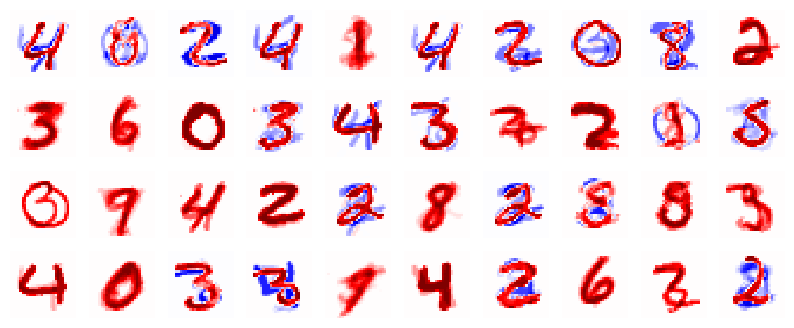

In [169]:
row_size = 10
col_size = int(layer_size / row_size)

figure(figsize=(row_size, col_size))

for col_idx in range(col_size):
    for row_idx in range(row_size):
        n_W_idx = col_idx * row_size + row_idx

        aimg = W[n_W_idx].reshape(img_side, img_side)

        subplot(col_size, row_size, n_W_idx + 1)

        imshow(aimg,
               interpolation='none',
               aspect='auto',
               cmap='seismic',
               vmax=np.max(np.abs(aimg)),
               vmin=-np.max(np.abs(aimg)))
        axis("off")

show()